In [1]:
import numpy as np
import pandas as pd
import nltk
import sklearn
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score
import scipy.stats as ss
import seaborn as sns
#nltk.download('stopwords')

# import the dataset
training_dataset = pd.read_csv('../answer-key/training_set.csv')
testing_dataset = pd.read_csv('../answer-key/testing_set.csv')

# preprocess dataset: remove stopwords, numeric, and stop characters
training_corpus = []
for i in range(0, 700):
    review = re.sub('[^a-zA-Z]', ' ', training_dataset['Review'][i])
    review = review.lower()
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    training_corpus.append(review)

# create bag of words model (use vectorization technique to convert textual data to numerical format), way to extract features from the text, find the frequency of each word
# create the transform (using count word occurrence), keyword will occur again and again, number of occurrences = importance of word
# more frequency means more importance
cv = CountVectorizer()

# # summarize
# print(cv.vocabulary_)

# #encode document
count_occurs_train = cv.fit_transform(training_corpus).toarray()
y_train = training_dataset.iloc[:, 2].values
# print(y_train)

# # training dataset -> used to fit the model, testing dataset -> used to perform the predictions

testing_corpus = []
for i in range(0, 300):
    review = re.sub('[^a-zA-Z]', ' ', testing_dataset['Review'][i])
    review = review.lower()
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    testing_corpus.append(review)

count_occurs_test = cv.transform(testing_corpus).toarray()
y_test = testing_dataset.iloc[:, 2].values

# SVM machine learning algorithm for classification, train the model
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(count_occurs_train,y_train)

# Predicting the test set results
predictions_SVM = SVM.predict(count_occurs_test)

cm = confusion_matrix(y_test, predictions_SVM)

print ("Confusion Matrix:\n",cm)
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, y_test) * 100, '%')
print("SVM Precision Score -> ", round(precision_score(predictions_SVM, y_test), 2))
print("SVM Recall Score -> ", round(recall_score(predictions_SVM, y_test), 2))

## Approximate Results: 
# SVM Accuracy Score ->  75.66666666666667 %
# SVM Precision Score ->  0.7
# SVM Recall Score ->  0.83

Confusion Matrix:
 [[110  25]
 [ 49 116]]
SVM Accuracy Score ->  75.33333333333333 %
SVM Precision Score ->  0.7
SVM Recall Score ->  0.82


In [3]:
business = pd.read_csv("cleaned_business.csv")
reviews = pd.read_csv("cleanish_reviews.csv") 
ids = pd.read_csv('list_buiss_id.txt', sep=" ", header=None)
ids.columns = ["id"]

In [4]:
columns = ["business_id", "business_name", "our_score", "stars"]
final_results = pd.DataFrame(columns=columns)

In [5]:
for i in range(len(ids)): 
    id_curr = ids.iloc[i].id
    
    #Review data that matches the current business id 
    all_reviews = reviews[reviews["business_id"] == id_curr]
    
    #vectorize the reviews for that resturant
    X_test = cv.transform(all_reviews["text"]).toarray()
    #creates the predicted sentiment for each review(with SVM)
    y_pred = SVM.predict(X_test)
    #you dont have to round 
    y_pred = np.mean(y_pred)*100
    #get the row in dataframe of current buis 
    curr_buis = business.loc[business['business_id'] == id_curr]
    #modify the star ratings to the same scale 
    curr_star = (curr_buis["stars"].values[0]/5)*100
    
    #update the final dataframe with all the info 
    final_results = final_results.append({"business_id":id_curr, "business_name":curr_buis["name"].values[0],"our_score":y_pred, "stars":curr_star}, ignore_index = True)

In [6]:
final_results.head()

,business_id,business_name,our_score,stars
0,s2B_ZeSGTlQ3qbm0dOY5rg,Hwy 55 Burgers Shakes & Fries,58.108108,60.0
1,tYYJYqbw1zasFUCqrkawKQ,Eagles Buffet,71.527778,70.0
2,wtDLILBaj5BGEbYvWGfNUw,Duck Donuts,88.333333,80.0
3,Mnu3EPpuzu3UUN1PIwFRoQ,Maui Pasta,92.307692,90.0
4,MrSHPvHVdE_VzVN7iRz45Q,Enso Asian Bistro & Sushi Bar,80.289855,70.0


In [7]:
ss.pearsonr(final_results["our_score"], final_results["stars"])

(0.8029082830984751, 9.542213002753587e-24)

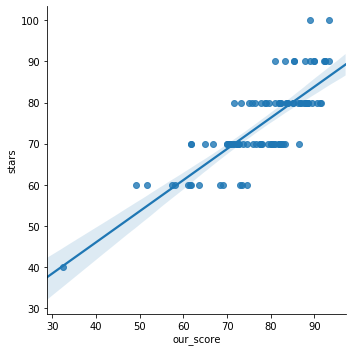

In [8]:
# visualize correlation with pretty graph
g = sns.lmplot(x="our_score", y="stars", data=final_results)

In [9]:
final_results.filter(items=["our_score",'stars']).corr()

,our_score,stars
our_score,1.000000,0.802908
stars,0.802908,1.000000
